# Churn Prediction

*Churn rate*, ou simplesmente *churn*, representa a taxa de evasão da sua base de clientes. Em serviços como Spotify ou Netflix, ela representaria a taxa de cancelamento de assinaturas.

<p align=center>
<img src="https://raw.githubusercontent.com/carlosfab/dsnp2/master/img/churnrate.jpg" width="60%"></p>

Ela é de extrema importância para a administração e sua análise ao longo do tempo pode mostrar que existe algum problema que deve ser atacado.

*Churn* também pode ser usado para identificar potenciais cancelamentos, com um tempo de antecedência, e promover ações direcionadas para tentar reter tais clientes. Essa métrica deve receber atenção pelo fato de que o Custo de Aquisição de Cliente (CAC) é normalmente mais alto que o custo para mantê-los. Ou seja, um alto valor para o *churn rate* é o que não desejamos.

## Aquisição dos Dados

Os dados utilizados neste projeto foram originalmente disponibilizados na plataforma de ensino da IBM Developer, e tratam de um problema típico de uma companhia de telecomunicações. O *dataset* completo pode ser encontrado [neste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Apesar de não haver informações explícitas disponíves, os nomes das colunas permitem um entendimento a respeito do problema.

In [ ]:
# importar os pacotes necessários
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report , confusion_matrix
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from lightgbm import LGBMClassifier

# importar os dados
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

# ver as 5 primeiras entradas
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### A visualização das 5 primeiras entradas já permite entender como o dataset está composto. Mesmo que não haja uma definição sobre o significado dos nomes das features, é possível inferir, uma vez que a natureza das empresas de telecomunicações são parecidas.

### Como se verifica abaixo, o dataset é composto de 7043 entradas e 21 variáveis.

In [ ]:
print("Linhas:\t\t{}".format(df.shape[0]))
print("Colunas:\t{}".format(df.shape[1]))

Linhas:		7043
Colunas:	21


## Análise Exploratória dos Dados

###A fim de começar este projeto, irei verificar a integridade e usabilidade do dataset.

### Para isso, deixarei impresso a quantidade de dados ausentes, os nomes das colunas, os tipos de variáveis por coluna e os valores únicos por coluna. Essa última, especificamente, vai auxiliar na identificação de variáveis potencialmente categóricas.

In [ ]:
print("Dados ausentes (total):\t{}\n".format(df.isnull().sum().values.sum()))
print(df.isnull().sum() / df.shape[0])
print("\nNomes das features:\n{}\n".format(df.columns.values))
print("Valores únicos (por coluna):\n{}\n".format(df.nunique()))
print("Tipos de Variáveis (por coluna)\n{}".format(df.dtypes))

Dados ausentes (total):	0

customerID          0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

Nomes das features:
['customerID' 'gender' 'SeniorCitizen' 'Partner' 'Dependents' 'tenure'
 'PhoneService' 'MultipleLines' 'InternetService' 'OnlineSecurity'
 'OnlineBackup' 'DeviceProtection' 'TechSupport' 'StreamingTV'
 'StreamingMovies' 'Contract' 'PaperlessBilling' 'PaymentMethod'
 'MonthlyCharges' 'TotalCharges' 'Churn']

Valores únicos (por coluna):
customerID          7043
gender                 2
SeniorCitizen          2
Partner             

* A coluna `costumerID` não agrega nenhuma informação, pois se trata de um identificador única para cada cliente.
* A variável alvo está na coluna `Churn`, indicando a situação de churn.
* A coluna `TotalCharges` deveria ser um `float`, mas está como `string`.
* Várias features precisam ser codificadas para valores numéricos.
    * Há várias features binárias, incluindo nossa variável alvo, ou com múltiplos valores, cada um representando uma categoria.

In [ ]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce') # Apenas 11 Nulos
df.dropna(subset=['TotalCharges'], inplace=True)
print(df.isnull().sum())


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


###Apesar deste dataset ser composto majoritariamente por variáveis binárias ou categóricas, é possível ver abaixo, pelo método `describe`, que não há indícios da presença de outliers.


In [ ]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


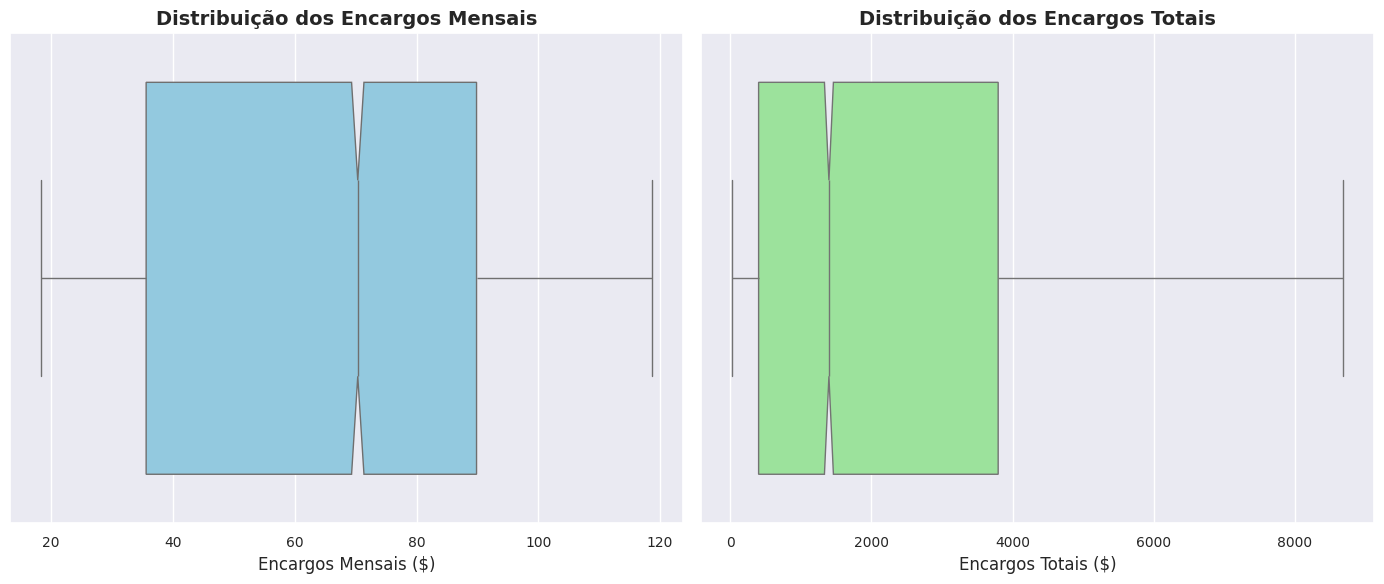

In [ ]:
sns.set(style="darkgrid")

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Boxplot para 'MonthlyCharges'
sns.boxplot(x=df['MonthlyCharges'], color='skyblue', ax=ax[0], notch=True)
ax[0].set_title('Distribuição dos Encargos Mensais', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Encargos Mensais ($)', fontsize=12)
ax[0].tick_params(axis='x', labelsize=10)

# Boxplot para 'TotalCharges'
sns.boxplot(x=df['TotalCharges'], color='lightgreen', ax=ax[1], notch=True)
ax[1].set_title('Distribuição dos Encargos Totais', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Encargos Totais ($)', fontsize=12)
ax[1].tick_params(axis='x', labelsize=10)

plt.tight_layout()

### O BoxPlot  reforça essa hipótese. O threshold padrão não acusou nenhum plot fora dos limites superior e inferior.



###Por fim, nesta primeira análise exploratória, vamos ver o balanceamento das classes do dataset.

###É possível identificar que a classe `No` ocorre com frequência muito superior à classe `Yes`. Isso será considerado na etapa de construção do modelo de machine learning.

<ipython-input-35-417ce4c173d7>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Churn',palette=['Green', 'Red'])


<Axes: xlabel='Churn', ylabel='count'>

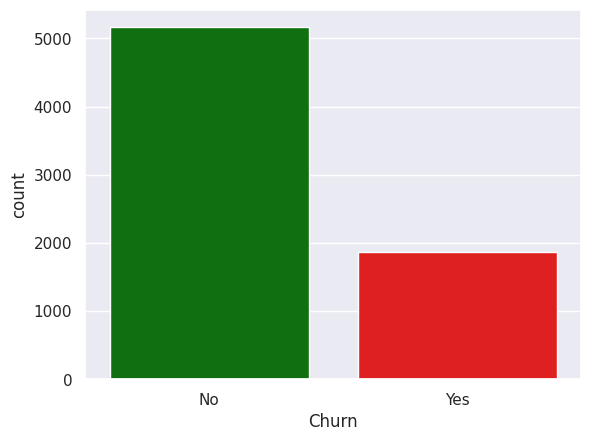

In [ ]:
sns.countplot(data=df, x='Churn',palette=['Green', 'Red'])

## Preparar os Dados

###Nesta etapa de preparação dos dados, será realizado um pré-processamento básico, apenas com a finalidade de construir um modelo base.

In [ ]:
df_ml = df.copy()
df_ml.drop(['customerID'], axis=1, inplace=True)

categorical_cols = df_ml.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df_ml.select_dtypes(include=['int64', 'float64']).columns.tolist()

ohe = OneHotEncoder(handle_unknown='ignore')
scaler = MinMaxScaler()

ohe_data = ohe.fit_transform(df_ml[categorical_cols])
ohe_df = pd.DataFrame(ohe_data.toarray(), columns=ohe.get_feature_names_out(categorical_cols))

df_ml = pd.concat([df_ml.drop(categorical_cols, axis=1), ohe_df], axis=1)
df_ml[numerical_cols] = scaler.fit_transform(df_ml[numerical_cols])
df_ml['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})
df_ml.drop(['Churn_No','Churn_Yes'],axis=1,inplace=True)
df_ml.dropna(inplace=True)
df_ml.head()


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,0.0,0.000000,0.115423,0.001275,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.464789,0.385075,0.215867,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.014085,0.354229,0.010310,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
3,0.0,0.619718,0.239303,0.210241,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.014085,0.521891,0.015330,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


## Modelo de Machine Learning

###Com o processamento realizado na etapa anterior, os dados já podem ser usados nos modelos de machine learning.
###Começarei utilizando um modelo simples de `regressão logistica` sem muitos hyperparâmetros

## Nesse caso consideraremos o Recall como métrica mais importante, principalmente por estarmos lidando com dados desbalanceados, e porque um churn classificado como falso positivo não é um grande problema quanto um falso negativo

In [ ]:
# Separar as features
X = df_ml.drop(['Churn'], axis=1)
y = df_ml['Churn']

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

lr_model = LogisticRegression(max_iter=1000,random_state=47)

scores = cross_val_score(lr_model, X, y, scoring='recall')
print("Recall: {:.2f} (+/- {:.2f})".format(scores.mean(), scores.std()))

Recall: 0.45 (+/- 0.02)



###Uma vez que temos um baseline para comparar se os ajustes melhoram ou pioram o desempenho do modelo, irei realizar o balanceamento dos dados e ver como isso irá impactar.

###A técnica escolhida foi Under Sampling, após alguns teste de desempenho das outras. Creio que com a quantidade de dados que se tem de Churn será possivel gerar um bom resultado. Os dados serão padronizados antes de usar essa técnica de balanceamento.

In [ ]:

scaler = MinMaxScaler().fit(X_train)

rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [ ]:
# instanciar modelos
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
sgdc = SGDClassifier()
svc = SVC()
lr = LogisticRegression()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

model = []
recall = []
# avaliar o desempenho (recall)
for clf in (rf, dt, sgdc, svc, lr, xgb, lgbm):
    model.append(clf.__class__.__name__)
    scores = cross_val_score(clf, X_train_rus, y_train_rus, scoring='recall')
    recall.append(scores.mean())

pd.DataFrame(data=recall, index=model, columns=['Recall'])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1119, number of negative: 1119
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 2238, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1119, number of negative: 1119
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 666
[LightGBM] [I

,Recall
RandomForestClassifier,0.694101
DecisionTreeClassifier,0.661910
SGDClassifier,0.867686
SVC,0.732673
LogisticRegression,0.744831
XGBClassifier,0.713387
LGBMClassifier,0.729839


###Dada as caracteristicas do problema e aprendizado, optei por utilizar o XGBoost

## Otimização dos Hiperparâmetros

XGBoost possui inúmeros parâmetros. Alguns afetam mais a qualidade do modelo, outros menos. Uma boa prática é definir uma taxa de aprendizado e número de estimadores, realizar tuning de outros parâmetros e, no final, checar outras taxas de aprendizado.

Abaixo, irei ajustar o número de estimadores. O modelo foi instanciado com a `learning_rate=0.1`.

In [ ]:
xgb = XGBClassifier(learning_rate=0.1)

param_grid = {
 'n_estimators':range(5,1000,50),
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.7391161356628982 para {'n_estimators': 105}


In [ ]:
xgb = XGBClassifier(learning_rate=0.1,n_estimators=55,)

param_grid = {
 'max_depth':range(1,8,1),
 'min_child_weight':range(1,5,1)
}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.7712538540596093 para {'max_depth': 3, 'min_child_weight': 3}


In [ ]:
xgb = XGBClassifier(learning_rate=0.1,n_estimators=55,max_depth=2,min_child_weight=3)

param_grid = {
 'gamma': [0,0.2,0.5],
 'colsample_bytree':[0.5,0.7,0.9]
}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.7576567317574512 para {'colsample_bytree': 0.9, 'gamma': 0.5}


###Por fim, obtido `gamma=0`, vou testar quatro valores para a `learning_rate` e ver qual oferece o melhor resultado.

In [ ]:
xgb = XGBClassifier(learning_rate=0.1,n_estimators=55, max_depth=2, min_child_weight=3, gamma=0.5,colsample_bytree=0.9)

param_grid = {
 'learning_rate':[0.01,0.1,0.2,0.3, 0.5]
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.7613052415210688 para {'learning_rate': 0.3}


###Agora, treina-se o modelo em cima do dataset de treino completo, e verifica-se o desempenho final em cima dos dados de teste, no seu primeiro contato com esse sub-conjunto que havia sido preservado.

              precision    recall  f1-score   support

         0.0       0.90      0.71      0.80      1289
         1.0       0.50      0.79      0.61       467

    accuracy                           0.73      1756
   macro avg       0.70      0.75      0.71      1756
weighted avg       0.80      0.73      0.75      1756



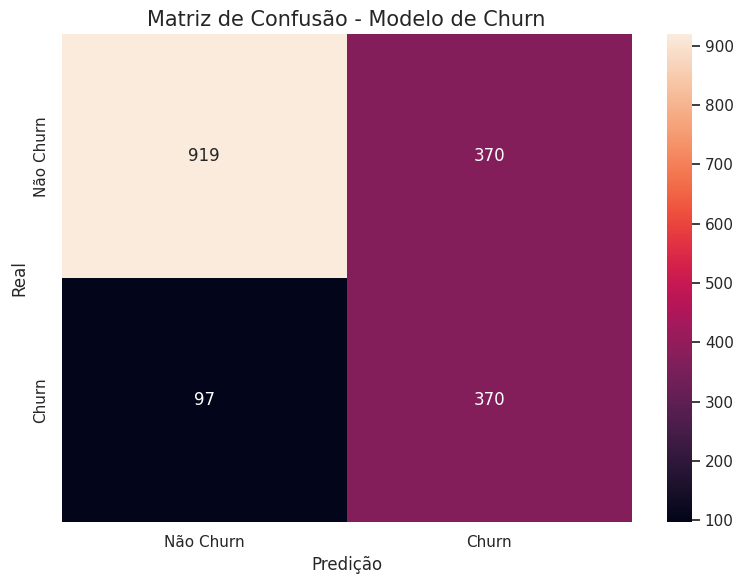

In [ ]:
# XGboost Model Final
xgb = XGBClassifier(learning_rate=0.1,n_estimators=55, max_depth=2, min_child_weight=3, gamma=0.5,colsample_bytree=0.9)
xgb.fit(X_train_rus, y_train_rus)

# fazer a previsão
X_test_scaled  = scaler.transform(X_test)
y_pred = xgb.predict(X_test_scaled )

# Classification Report
print(classification_report(y_test, y_pred))

# Gerar a Matrix de confusão

cm = confusion_matrix(y_test, y_pred)

classes = ['Não Churn', 'Churn']

plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cbar=True,
            xticklabels=classes, yticklabels=classes)

plt.xlabel('Predição', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.title('Matriz de Confusão - Modelo de Churn', fontsize=15)

plt.tight_layout()
plt.show()

<ipython-input-45-de6302b2ccb9>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')


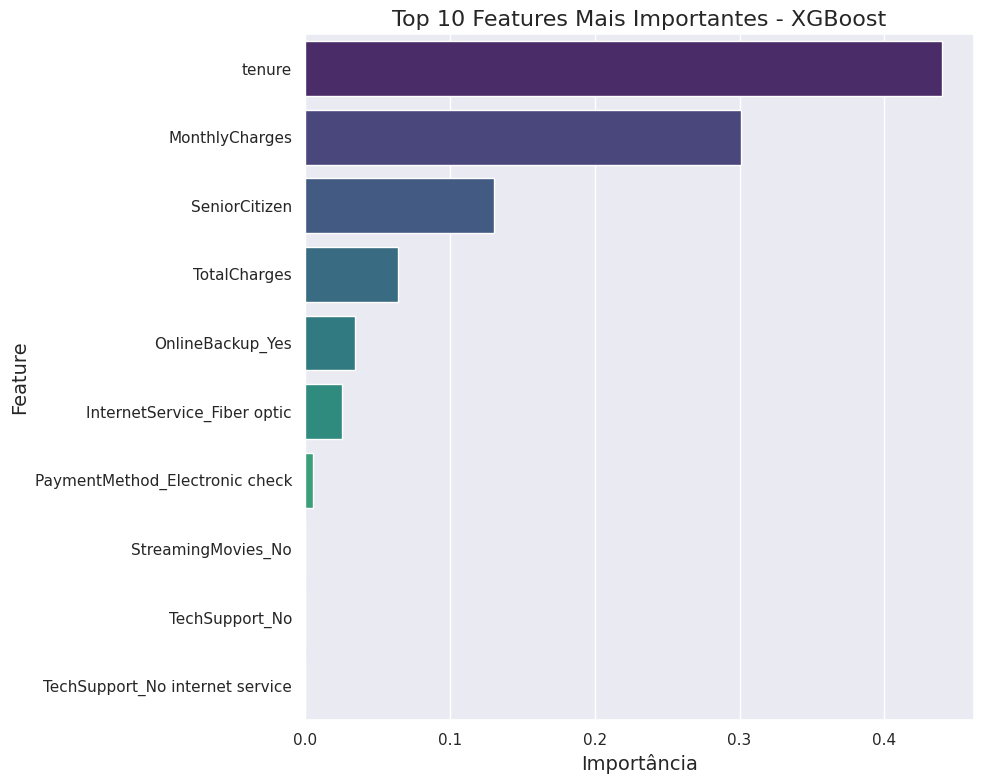

In [ ]:
feature_names = X_train_rus.columns
importances = xgb.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Ordenar as features pela importância
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
top_n = 10

# Selecionar as top N features
top_features = feature_importance.head(top_n)

# Plotar
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title(f'Top {top_n} Features Mais Importantes - XGBoost', fontsize=16)
plt.xlabel('Importância', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()

## Com esse grafico notamos as features que foram mais importantes para o modelo, a primeira foi a tenure, faz muito sentido, pois isso refere-se ao período de tempo que um cliente tem mantido um contrato com a empresa, logo, provavelmente, os clientes que estão a pouco tempo na empresa, tem a tendência de sair mais facilmente do que os que estão há muito tempo, conseguimos complementar isso ja com a segunda feature, que é o gasto mensal, é muito provavel que em caso de um aumento no valor da assinatura gere um churn.

#Feature Engineering

In [ ]:
print(df['Contract'].value_counts())
# A maioria dos contratos da empresa é mensal.

# Implementando novas features:
df_featured = df.copy()
df_featured['Tempo_Cliente'] = pd.qcut(df_ml['tenure'], q=4, labels=['Curto', 'Médio', 'Longo', 'Muito Longo'])



service_cols = ['PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

service_mapping = {'Yes': 1, 'No': 0, 'No internet service': 0, 'No phone service': 0}

for col in service_cols:
    df_featured[col] = df_featured[col].replace(service_mapping)

df_featured['NumServicos'] = df_featured[service_cols].sum(axis=1)

Contract
Month-to-month    3875
Two year          1685
One year          1472
Name: count, dtype: int64


<ipython-input-46-c18ea09a0cc0>:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_featured[col] = df_featured[col].replace(service_mapping)


## Agora tentarei refazer o mesmo modelo de ML, porém utilizando 2 novas features e removendo algumas outras

In [ ]:
df_featured = df_featured[['gender','SeniorCitizen','Partner','Dependents','Contract','PaperlessBilling',	'PaymentMethod',	'MonthlyCharges',	'TotalCharges',	'Churn','Tempo_Cliente','NumServicos']]

In [ ]:
xgb = XGBClassifier(learning_rate=0.1,n_estimators=55, max_depth=2, min_child_weight=3, gamma=0.5,colsample_bytree=0.9)

# Separar as features
X = df_featured.drop(['Churn'], axis=1)
y = df_featured['Churn']
y = y.map({'No': 0, 'Yes': 1})

# Identificar colunas categóricas e numéricas
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
#Usando o balanceamento
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

# Fazer o pré processamento das colunas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('min_max', MinMaxScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ]
)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb)
])


featured_xgb = pipeline.fit(X_train_rus, y_train_rus)

y_pred = featured_xgb.predict(X_test)


              precision    recall  f1-score   support

           0       0.91      0.69      0.79      1291
           1       0.49      0.82      0.61       467

    accuracy                           0.72      1758
   macro avg       0.70      0.75      0.70      1758
weighted avg       0.80      0.72      0.74      1758



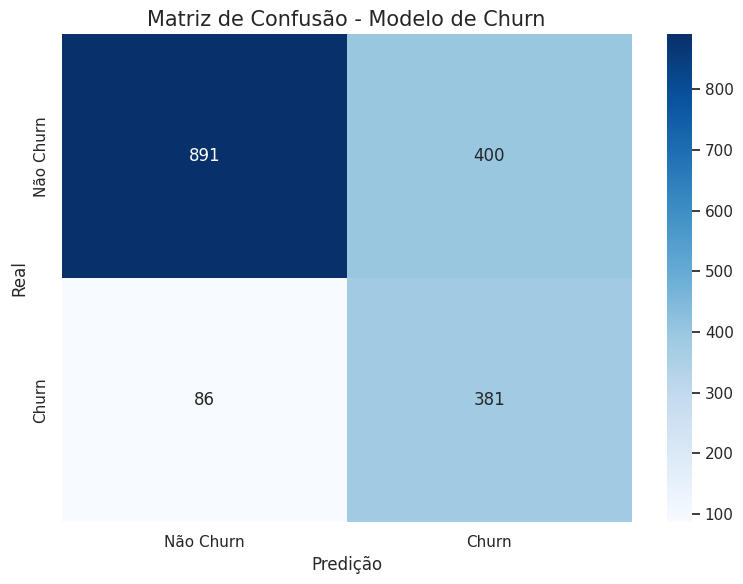

In [ ]:
print(classification_report(y_test, y_pred))
# Gerar a Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)

# Definir os rótulos das classes
classes = ['Não Churn', 'Churn']

# Plotar a Matriz de Confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)

plt.xlabel('Predição', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.title('Matriz de Confusão - Modelo de Churn', fontsize=15)
plt.tight_layout()
plt.show()

## Houve uma pequena melhora, porém não houve uma diferença significativa utilizando essas features no mesmo modelo. Porém chegamos a um bom resultado, tendo uma previsão de 82% de clientes que poderiam deixar de assinar o seu plano na empresa. Com isso a empresa pode tomar decisões antecipadas, para tentar evitar o churn, como: promoções, bonûs e programas de fidelidade.